In [1]:
# Import needed files and basic setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

import data_gen2
import tropical

from ipywidgets import Output
from IPython.display import display, Markdown, Latex, Math, clear_output

from sklearn.neighbors import NearestNeighbors

import math

from cvxopt import solvers, matrix

import time

%matplotlib notebook
#plt.ion()

In [2]:
# Hyperparameters
n_epochs = 100
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 100

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
# Load training and testing sets
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [5]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum, weight_decay=learning_rate)

In [6]:
train_losses = []
train_acc = []
train_counter = []
test_losses = []
test_acc = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [7]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            pred = output.data.max(1, keepdim=True)[1]
            correct = pred.eq(target.data.view_as(pred)).sum()
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.6f}'.format(
                  epoch, batch_idx * len(data), len(train_loader.dataset),
                  100. * batch_idx / len(train_loader), loss.item(), 100. * correct / 64))
            
            train_losses.append(loss.item())
            train_acc.append(100. * correct / 64)
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [8]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_acc.append(100. * correct / len(test_loader.dataset))
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))

In [9]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

/home/ben/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/ben/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.2975, Accuracy: 1076/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.310654	Accuracy: 12.000000
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.781065	Accuracy: 78.000000
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.737908	Accuracy: 81.000000
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.444616	Accuracy: 92.000000
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.530826	Accuracy: 84.000000
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.448208	Accuracy: 85.000000
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.386039	Accuracy: 90.000000
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.346159	Accuracy: 89.000000
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.622710	Accuracy: 78.000000
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.211085	Accuracy: 93.000000

Test set: Avg. loss: 0.2884, Accuracy: 9213/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.573400	Accuracy: 81.000000
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.348063	Accuracy: 87.000000
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.484070	Accura

Train Epoch: 11 [57600/60000 (96%)]	Loss: 0.214196	Accuracy: 92.000000

Test set: Avg. loss: 0.1608, Accuracy: 9570/10000 (95%)

Train Epoch: 12 [0/60000 (0%)]	Loss: 0.172852	Accuracy: 96.000000
Train Epoch: 12 [6400/60000 (11%)]	Loss: 0.232039	Accuracy: 93.000000
Train Epoch: 12 [12800/60000 (21%)]	Loss: 0.248254	Accuracy: 95.000000
Train Epoch: 12 [19200/60000 (32%)]	Loss: 0.158068	Accuracy: 96.000000
Train Epoch: 12 [25600/60000 (43%)]	Loss: 0.167331	Accuracy: 95.000000
Train Epoch: 12 [32000/60000 (53%)]	Loss: 0.242649	Accuracy: 93.000000
Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.189358	Accuracy: 95.000000
Train Epoch: 12 [44800/60000 (75%)]	Loss: 0.244398	Accuracy: 93.000000
Train Epoch: 12 [51200/60000 (85%)]	Loss: 0.226223	Accuracy: 92.000000
Train Epoch: 12 [57600/60000 (96%)]	Loss: 0.308978	Accuracy: 90.000000

Test set: Avg. loss: 0.1583, Accuracy: 9570/10000 (95%)

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.366405	Accuracy: 87.000000
Train Epoch: 13 [6400/60000 (11%)]	Loss: 0.

Train Epoch: 22 [44800/60000 (75%)]	Loss: 0.268762	Accuracy: 90.000000
Train Epoch: 22 [51200/60000 (85%)]	Loss: 0.111646	Accuracy: 96.000000
Train Epoch: 22 [57600/60000 (96%)]	Loss: 0.325124	Accuracy: 90.000000

Test set: Avg. loss: 0.1540, Accuracy: 9594/10000 (95%)

Train Epoch: 23 [0/60000 (0%)]	Loss: 0.150479	Accuracy: 96.000000
Train Epoch: 23 [6400/60000 (11%)]	Loss: 0.244726	Accuracy: 93.000000
Train Epoch: 23 [12800/60000 (21%)]	Loss: 0.277275	Accuracy: 90.000000
Train Epoch: 23 [19200/60000 (32%)]	Loss: 0.117137	Accuracy: 98.000000
Train Epoch: 23 [25600/60000 (43%)]	Loss: 0.200329	Accuracy: 95.000000
Train Epoch: 23 [32000/60000 (53%)]	Loss: 0.206658	Accuracy: 96.000000
Train Epoch: 23 [38400/60000 (64%)]	Loss: 0.212381	Accuracy: 95.000000
Train Epoch: 23 [44800/60000 (75%)]	Loss: 0.157625	Accuracy: 96.000000
Train Epoch: 23 [51200/60000 (85%)]	Loss: 0.094540	Accuracy: 100.000000
Train Epoch: 23 [57600/60000 (96%)]	Loss: 0.229478	Accuracy: 93.000000

Test set: Avg. loss: 0.

Train Epoch: 33 [32000/60000 (53%)]	Loss: 0.167581	Accuracy: 96.000000
Train Epoch: 33 [38400/60000 (64%)]	Loss: 0.164593	Accuracy: 93.000000
Train Epoch: 33 [44800/60000 (75%)]	Loss: 0.206212	Accuracy: 98.000000
Train Epoch: 33 [51200/60000 (85%)]	Loss: 0.206265	Accuracy: 95.000000
Train Epoch: 33 [57600/60000 (96%)]	Loss: 0.298639	Accuracy: 92.000000

Test set: Avg. loss: 0.1517, Accuracy: 9604/10000 (96%)

Train Epoch: 34 [0/60000 (0%)]	Loss: 0.150753	Accuracy: 93.000000
Train Epoch: 34 [6400/60000 (11%)]	Loss: 0.229701	Accuracy: 95.000000
Train Epoch: 34 [12800/60000 (21%)]	Loss: 0.251712	Accuracy: 93.000000
Train Epoch: 34 [19200/60000 (32%)]	Loss: 0.228578	Accuracy: 93.000000
Train Epoch: 34 [25600/60000 (43%)]	Loss: 0.327955	Accuracy: 90.000000
Train Epoch: 34 [32000/60000 (53%)]	Loss: 0.210572	Accuracy: 95.000000
Train Epoch: 34 [38400/60000 (64%)]	Loss: 0.215650	Accuracy: 95.000000
Train Epoch: 34 [44800/60000 (75%)]	Loss: 0.184548	Accuracy: 93.000000
Train Epoch: 34 [51200/60

Train Epoch: 44 [19200/60000 (32%)]	Loss: 0.243446	Accuracy: 90.000000
Train Epoch: 44 [25600/60000 (43%)]	Loss: 0.199424	Accuracy: 95.000000
Train Epoch: 44 [32000/60000 (53%)]	Loss: 0.115544	Accuracy: 96.000000
Train Epoch: 44 [38400/60000 (64%)]	Loss: 0.247688	Accuracy: 92.000000
Train Epoch: 44 [44800/60000 (75%)]	Loss: 0.107564	Accuracy: 96.000000
Train Epoch: 44 [51200/60000 (85%)]	Loss: 0.150808	Accuracy: 95.000000
Train Epoch: 44 [57600/60000 (96%)]	Loss: 0.174067	Accuracy: 95.000000

Test set: Avg. loss: 0.1488, Accuracy: 9609/10000 (96%)

Train Epoch: 45 [0/60000 (0%)]	Loss: 0.118162	Accuracy: 96.000000
Train Epoch: 45 [6400/60000 (11%)]	Loss: 0.210292	Accuracy: 92.000000
Train Epoch: 45 [12800/60000 (21%)]	Loss: 0.152668	Accuracy: 95.000000
Train Epoch: 45 [19200/60000 (32%)]	Loss: 0.207458	Accuracy: 93.000000
Train Epoch: 45 [25600/60000 (43%)]	Loss: 0.125033	Accuracy: 98.000000
Train Epoch: 45 [32000/60000 (53%)]	Loss: 0.186644	Accuracy: 98.000000
Train Epoch: 45 [38400/60

Train Epoch: 55 [6400/60000 (11%)]	Loss: 0.208131	Accuracy: 96.000000
Train Epoch: 55 [12800/60000 (21%)]	Loss: 0.237437	Accuracy: 93.000000
Train Epoch: 55 [19200/60000 (32%)]	Loss: 0.196011	Accuracy: 93.000000
Train Epoch: 55 [25600/60000 (43%)]	Loss: 0.173937	Accuracy: 93.000000
Train Epoch: 55 [32000/60000 (53%)]	Loss: 0.297420	Accuracy: 92.000000
Train Epoch: 55 [38400/60000 (64%)]	Loss: 0.186687	Accuracy: 96.000000
Train Epoch: 55 [44800/60000 (75%)]	Loss: 0.179328	Accuracy: 96.000000
Train Epoch: 55 [51200/60000 (85%)]	Loss: 0.127337	Accuracy: 98.000000
Train Epoch: 55 [57600/60000 (96%)]	Loss: 0.119749	Accuracy: 100.000000

Test set: Avg. loss: 0.1469, Accuracy: 9618/10000 (96%)

Train Epoch: 56 [0/60000 (0%)]	Loss: 0.201805	Accuracy: 96.000000
Train Epoch: 56 [6400/60000 (11%)]	Loss: 0.165950	Accuracy: 96.000000
Train Epoch: 56 [12800/60000 (21%)]	Loss: 0.094982	Accuracy: 98.000000
Train Epoch: 56 [19200/60000 (32%)]	Loss: 0.296279	Accuracy: 90.000000
Train Epoch: 56 [25600/60


Test set: Avg. loss: 0.1472, Accuracy: 9615/10000 (96%)

Train Epoch: 66 [0/60000 (0%)]	Loss: 0.328436	Accuracy: 89.000000
Train Epoch: 66 [6400/60000 (11%)]	Loss: 0.262363	Accuracy: 92.000000
Train Epoch: 66 [12800/60000 (21%)]	Loss: 0.080330	Accuracy: 100.000000
Train Epoch: 66 [19200/60000 (32%)]	Loss: 0.291892	Accuracy: 87.000000
Train Epoch: 66 [25600/60000 (43%)]	Loss: 0.438142	Accuracy: 87.000000
Train Epoch: 66 [32000/60000 (53%)]	Loss: 0.190120	Accuracy: 92.000000
Train Epoch: 66 [38400/60000 (64%)]	Loss: 0.312747	Accuracy: 92.000000
Train Epoch: 66 [44800/60000 (75%)]	Loss: 0.344767	Accuracy: 90.000000
Train Epoch: 66 [51200/60000 (85%)]	Loss: 0.290465	Accuracy: 90.000000
Train Epoch: 66 [57600/60000 (96%)]	Loss: 0.230028	Accuracy: 92.000000

Test set: Avg. loss: 0.1463, Accuracy: 9624/10000 (96%)

Train Epoch: 67 [0/60000 (0%)]	Loss: 0.151721	Accuracy: 96.000000
Train Epoch: 67 [6400/60000 (11%)]	Loss: 0.210524	Accuracy: 93.000000
Train Epoch: 67 [12800/60000 (21%)]	Loss: 0

Train Epoch: 76 [51200/60000 (85%)]	Loss: 0.300302	Accuracy: 90.000000
Train Epoch: 76 [57600/60000 (96%)]	Loss: 0.191662	Accuracy: 93.000000

Test set: Avg. loss: 0.1449, Accuracy: 9624/10000 (96%)

Train Epoch: 77 [0/60000 (0%)]	Loss: 0.342108	Accuracy: 89.000000
Train Epoch: 77 [6400/60000 (11%)]	Loss: 0.166637	Accuracy: 93.000000
Train Epoch: 77 [12800/60000 (21%)]	Loss: 0.147097	Accuracy: 96.000000
Train Epoch: 77 [19200/60000 (32%)]	Loss: 0.152814	Accuracy: 95.000000
Train Epoch: 77 [25600/60000 (43%)]	Loss: 0.226932	Accuracy: 93.000000
Train Epoch: 77 [32000/60000 (53%)]	Loss: 0.120197	Accuracy: 96.000000
Train Epoch: 77 [38400/60000 (64%)]	Loss: 0.338274	Accuracy: 89.000000
Train Epoch: 77 [44800/60000 (75%)]	Loss: 0.149522	Accuracy: 96.000000
Train Epoch: 77 [51200/60000 (85%)]	Loss: 0.279099	Accuracy: 89.000000
Train Epoch: 77 [57600/60000 (96%)]	Loss: 0.151366	Accuracy: 96.000000

Test set: Avg. loss: 0.1461, Accuracy: 9622/10000 (96%)

Train Epoch: 78 [0/60000 (0%)]	Loss: 0

Train Epoch: 87 [38400/60000 (64%)]	Loss: 0.215224	Accuracy: 95.000000
Train Epoch: 87 [44800/60000 (75%)]	Loss: 0.280666	Accuracy: 93.000000
Train Epoch: 87 [51200/60000 (85%)]	Loss: 0.196021	Accuracy: 95.000000
Train Epoch: 87 [57600/60000 (96%)]	Loss: 0.181011	Accuracy: 95.000000

Test set: Avg. loss: 0.1477, Accuracy: 9608/10000 (96%)

Train Epoch: 88 [0/60000 (0%)]	Loss: 0.155937	Accuracy: 95.000000
Train Epoch: 88 [6400/60000 (11%)]	Loss: 0.224790	Accuracy: 95.000000
Train Epoch: 88 [12800/60000 (21%)]	Loss: 0.161649	Accuracy: 93.000000
Train Epoch: 88 [19200/60000 (32%)]	Loss: 0.212440	Accuracy: 93.000000
Train Epoch: 88 [25600/60000 (43%)]	Loss: 0.170330	Accuracy: 96.000000
Train Epoch: 88 [32000/60000 (53%)]	Loss: 0.126024	Accuracy: 96.000000
Train Epoch: 88 [38400/60000 (64%)]	Loss: 0.239929	Accuracy: 90.000000
Train Epoch: 88 [44800/60000 (75%)]	Loss: 0.191327	Accuracy: 96.000000
Train Epoch: 88 [51200/60000 (85%)]	Loss: 0.203925	Accuracy: 93.000000
Train Epoch: 88 [57600/60

Train Epoch: 98 [25600/60000 (43%)]	Loss: 0.154631	Accuracy: 95.000000
Train Epoch: 98 [32000/60000 (53%)]	Loss: 0.133064	Accuracy: 96.000000
Train Epoch: 98 [38400/60000 (64%)]	Loss: 0.157920	Accuracy: 96.000000
Train Epoch: 98 [44800/60000 (75%)]	Loss: 0.264809	Accuracy: 90.000000
Train Epoch: 98 [51200/60000 (85%)]	Loss: 0.109748	Accuracy: 98.000000
Train Epoch: 98 [57600/60000 (96%)]	Loss: 0.142652	Accuracy: 96.000000

Test set: Avg. loss: 0.1462, Accuracy: 9612/10000 (96%)

Train Epoch: 99 [0/60000 (0%)]	Loss: 0.164180	Accuracy: 98.000000
Train Epoch: 99 [6400/60000 (11%)]	Loss: 0.126684	Accuracy: 98.000000
Train Epoch: 99 [12800/60000 (21%)]	Loss: 0.188470	Accuracy: 90.000000
Train Epoch: 99 [19200/60000 (32%)]	Loss: 0.090832	Accuracy: 100.000000
Train Epoch: 99 [25600/60000 (43%)]	Loss: 0.155635	Accuracy: 95.000000
Train Epoch: 99 [32000/60000 (53%)]	Loss: 0.239388	Accuracy: 93.000000
Train Epoch: 99 [38400/60000 (64%)]	Loss: 0.195095	Accuracy: 95.000000
Train Epoch: 99 [44800/6

<IPython.core.display.Javascript object>


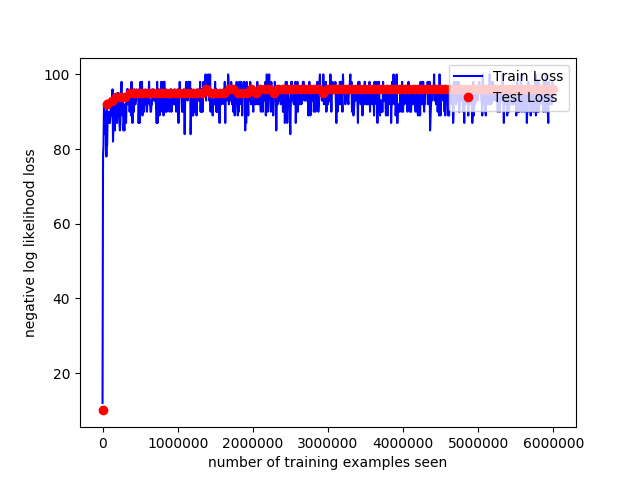

Text(0,0.5,'negative log likelihood loss')

In [10]:
fig = plt.figure()
plt.plot(train_counter, train_acc, color='blue')
plt.plot(test_counter, test_acc, 'o', color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [11]:
params = []
for param in network.parameters():
    params.append(param.detach().numpy())

A1 = params[0]
b1 = params[1]
A2 = params[2]
b2 = params[3]

In [12]:
np.savez('parametersRegularizedMore', A1=A1, b1=b1, A2=A2, b2=b2)